# Before starting...

⚠️ We advise against running this on kaggle directly, but instead downloading the notebooks to your system as training each model take several hours and you will need to download and re-upload your dataset.

This notebook is aimed for creating the dataset to run the MultiOrg object-detection benchmark from the raw MultiOrg data.

Download database here: https://www.kaggle.com/datasets/christinabukas/mutliorg/data

Run the following code according to your os, if you are on linux there will be problems with the repo names, be careful.

## Imports

In [6]:
import time, os, sys
import json
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
from skimage.io import imread, imsave
import matplotlib.pyplot as plt

## Useful functions

In [7]:
def load_img(img_path):
    """ Load the image, make sure the background area is set to 0 and normalise the image. """
    img = imread(img_path)
    img = np.squeeze(img.data)
    img[img<50] = 0
    # done on cropped image level
    #img = (img-np.min(img))/(np.max(img)-np.min(img))
    #img = (255*img).astype(np.uint8)
    return img

def load_annotations(json_path, img_height, img_width):
    """ Load annotations from json file - each box will be stored in the following format:
    --- P0(x1, y1) -> top left point of box
    --- P1(x2, y1) -> bottom left
    --- P2(x2, y2) -> bottom right
    --- P3(x1, y2) -> top right
    The boxes are returned already in the coco convention [x, y, width, height] -> x and y are here switched
    compared to the way we stored data.
    """
    f = open(json_path)
    annot = json.load(f)
    bboxes = []
    for key in annot.keys():
        
        # read and swap x and y
        x1 = round(annot[key][0][1])
        y1 = round(annot[key][0][0])
        x2 = round(annot[key][2][1])
        y2 = round(annot[key][2][0])
            
        # make sure coordinates don't fall outside image
        x1 = max(0, x1)
        x2 = max(0, x2)
        y1 = max(0, y1)
        y2 = max(0, y2)
        x1 = min(img_width, x1)
        x2 = min(img_width, x2)
        y1 = min(img_height, y1)
        y2 = min(img_height, y2)
        # and swap if so that x1 and y1 always larger than x2 and y2
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1
        # finally compute width and height
        w = x2 - x1
        h = y2 - y1
        # check everything is ok!
        assert h>=0, "Height: "+str(h)
        assert w>=0, "Width: "+str(w)
        assert x1>=0, "x1: "+str(x1)
        assert y1>=0, "y1: "+str(y1)
        assert x1<=img_width, "x1: "+str(x1)
        assert y1<=img_height, "y1: "+str(y1)
        assert (x1+w)<=img_width, "x1: "+str(x1)+" Width: "+str(w)
        assert(y1+h)<=img_height, "y1: "+str(y1)+" Height: "+str(h)
        
        bboxes.append([x1, y1, w, h])
        
    return bboxes

def test_same_files(img_list, annot_list):
    """ makes sure annotation corresponds to image, i.e. taht they come from the same data directory. """
    for l in range(len(img_list)):
        directory1 = os.path.dirname(img_list[l])
        directory2 = os.path.dirname(annot_list[l])
        assert directory1 == directory2

def pad_img(img, img_height, img_width, crop_size=512):
    """ Pad the image on the right and bottom, so that it is dividable n both dims with crop_size. """
    img_height, img_width = img.shape
    pad_x = crop_size - img_width%crop_size
    pad_y = crop_size - img_height%crop_size
    img_padded = np.pad(img, ((0, pad_y), (0, pad_x)))
    return img_padded


def crop_img(img_padded,
             img_height,
             img_width,
             img_annotations,
             img_src_filename,
             crop_size,
             dst_folder,
             images_json,
             img_id,
             annotator,
             annotations_json,
             obj_count):
    """ Crop each image into crops of size crop_sizexcrop_size and if annotations exist within the crop save the image and
    store the information on image and annotation.
    """
    # used to compute the name of the file to be saved.
    fnm_split = img_src_filename.split('\\') ## attention l'opérateur dépend du système d'exploitation
    exp_type = fnm_split[-4]
    exp_name = fnm_split[-3]
    img_name = fnm_split[-2]
    print(exp_type, exp_name, img_name)

    for i in range(0, img_height, crop_size):
        for j in range(0, img_width, crop_size):
            # crop image
            img_crop = img_padded[i:(i+crop_size), j:(j+crop_size)]
            savename = "_".join([exp_type, exp_name, img_name, "patch", str(i//crop_size), str(j//crop_size)+".jpg"])
            img_dst = os.path.join(dst_folder, savename)
            if np.mean(img_crop)<50: continue             
            # check if box is inside the patch
            crop_boxes = []
            for bbox in img_annotations:
                x1, y1, w, h = bbox                    
                if x1 >= j and (x1 + w) < (j + crop_size) and y1 >= i and (y1 + h) < (i + crop_size) and h > 0 and w > 0:
                    x1 -= j 
                    y1 -= i
                    crop_boxes.append([x1, y1, w, h])
            # only save image if there is at least one bounding box in there        
            if len(crop_boxes)>0:
                # normalise and save
                img_crop = (img_crop-np.min(img_crop))/(np.max(img_crop)-np.min(img_crop))
                img_crop = (255*img_crop).astype(np.uint8)
                imsave(img_dst, img_crop)
                # store image info
                images_json.append(dict(id=img_id,
                                        file_name = savename,
                                        height=img_height,
                                        width=img_width,
                                        annotator=annotator)
                                  )
                # and store all bounding boxes which are fully in crop
                for bbox in crop_boxes:
                    annotations_json.append(dict(image_id=img_id,
                                                 id=obj_count,
                                                 category_id=0,
                                                 bbox=bbox,
                                                 area=h*w,
                                                 iscrowd=0)
                                           )
                    obj_count += 1
                # increase image id since we successfully saved an image
                img_id += 1    
            
    return images_json, img_id, annotations_json, obj_count

## Create a dataset of cropped patches of the image split into train and test with labels in the coco format

In [8]:
crop_size = 512
root_path_train = os.path.join("5", "train") # Utiliser os.path.join partout
root_path_test = os.path.join("5", "test")
path_splits = {'train': root_path_train, 'test': root_path_test}
root_dst = os.path.join(".", 'multiorg_mmdet_coco')

# for each data split
for split in ['train', 'test']:

    # get list of images and annotations
    img_list = sorted(list(set(glob(os.path.join(path_splits[split], "**", "**", "*.tiff"), recursive=True))))
    annot_list = sorted(list(set(glob(os.path.join(path_splits[split], "**", "**","*.json"), recursive=True))))
    if split=="test": split = "val" # rename so test_0 is used as validation set for early stopping  
    # and make sure number of images and annotation files match
    assert len(img_list)==len(annot_list)
    test_same_files(img_list, annot_list)
    print("NUMBER OF IMAGES AND ANNOTATIONS IN ", split, "is :", len(img_list))

    # create folder to save images if it doesn't exist
    dst_split = os.path.join(root_dst, split)
    if not os.path.exists(dst_split): os.makedirs(dst_split)

    images_json = []
    img_id = 0
    obj_count = 0
    annotations_json = []
    # go through each image in the split, create crops and annotations for that crop and save image
    for i in tqdm(range(len(img_list)), desc="Cropping images"):
        try:
            # load image and compute height and width
            img = load_img(img_list[i])
            img_height, img_width = img.shape[0], img.shape[1]
            # load bboxes for image
            bboxes = load_annotations(annot_list[i], img_height, img_width)
            annotator = annot_list[i].split('_')[-1].split('.')[0]
            
            # pad image so that we can crop equally
            img_padded = pad_img(img, img_height, img_width, crop_size)
            # crop image and save results
            images_json, img_id, annotations_json, obj_count = crop_img(img_padded,
                                                            img_height,
                                                            img_width,
                                                            bboxes,
                                                            img_list[i],
                                                            crop_size,
                                                            dst_split,
                                                            images_json,
                                                            img_id,
                                                            annotator,
                                                            annotations_json,
                                                            obj_count)

        except: 
                print("ERROR with files: ", img_list[i], annot_list[i])
                exit(1)
            
    # create a dict with all info on images and annotations - we only have 1 class so add class '0' only under categories
    coco_format_json = dict(images=images_json,
                            annotations=annotations_json,
                            categories=[{'id': 0,
                                         'name': 'organoid'}]
                           )
    dst_json = os.path.join(root_dst, split+".json")
    # save the json file 
    with open(dst_json, "wb") as f:
        f.write(json.dumps(coco_format_json,default=int).encode("utf-8"))

NUMBER OF IMAGES AND ANNOTATIONS IN  train is : 356


Cropping images:   0%|          | 0/356 [00:00<?, ?it/s]

Macros Plate_13 image_0


Cropping images:   0%|          | 1/356 [00:01<09:13,  1.56s/it]

Macros Plate_13 image_1


Cropping images:   1%|          | 2/356 [00:03<09:00,  1.53s/it]

Macros Plate_13 image_2


Cropping images:   1%|          | 3/356 [00:04<08:18,  1.41s/it]

Macros Plate_13 image_3


Cropping images:   1%|          | 4/356 [00:05<07:33,  1.29s/it]

Macros Plate_13 image_4


Cropping images:   1%|▏         | 5/356 [00:06<07:27,  1.27s/it]

Macros Plate_13 image_5


Cropping images:   2%|▏         | 6/356 [00:07<07:21,  1.26s/it]

Macros Plate_16 image_0


Cropping images:   2%|▏         | 7/356 [00:08<06:46,  1.16s/it]

Macros Plate_16 image_1


Cropping images:   2%|▏         | 8/356 [00:10<06:51,  1.18s/it]

Macros Plate_16 image_2


Cropping images:   3%|▎         | 9/356 [00:11<06:30,  1.13s/it]

Macros Plate_16 image_3


Cropping images:   3%|▎         | 10/356 [00:12<06:08,  1.07s/it]

Macros Plate_16 image_4


Cropping images:   3%|▎         | 11/356 [00:13<06:06,  1.06s/it]

Macros Plate_16 image_5


Cropping images:   3%|▎         | 12/356 [00:14<06:08,  1.07s/it]

Macros Plate_16 image_6


Cropping images:   4%|▎         | 13/356 [00:15<06:03,  1.06s/it]

Macros Plate_16 image_7


Cropping images:   4%|▍         | 14/356 [00:16<05:44,  1.01s/it]

Macros Plate_16 image_8


Cropping images:   4%|▍         | 15/356 [00:17<05:58,  1.05s/it]

Macros Plate_17 image_0


Cropping images:   4%|▍         | 16/356 [00:18<06:22,  1.12s/it]

Macros Plate_17 image_1


Cropping images:   5%|▍         | 17/356 [00:19<06:43,  1.19s/it]

Macros Plate_17 image_2


Cropping images:   5%|▌         | 18/356 [00:21<06:37,  1.18s/it]

Macros Plate_17 image_3


Cropping images:   5%|▌         | 19/356 [00:22<07:02,  1.25s/it]

Macros Plate_18 image_0


Cropping images:   6%|▌         | 20/356 [00:23<07:18,  1.31s/it]

Macros Plate_18 image_1


Cropping images:   6%|▌         | 21/356 [00:25<07:47,  1.40s/it]

Macros Plate_18 image_2


Cropping images:   6%|▌         | 22/356 [00:26<07:43,  1.39s/it]

Macros Plate_18 image_3


Cropping images:   6%|▋         | 23/356 [00:28<07:20,  1.32s/it]

Macros Plate_18 image_4


Cropping images:   7%|▋         | 24/356 [00:29<07:05,  1.28s/it]

Macros Plate_18 image_5


Cropping images:   7%|▋         | 25/356 [00:30<07:23,  1.34s/it]

Macros Plate_25 image_0


Cropping images:   7%|▋         | 26/356 [00:32<07:23,  1.34s/it]

Macros Plate_25 image_1


Cropping images:   8%|▊         | 27/356 [00:33<06:46,  1.23s/it]

Macros Plate_25 image_2


Cropping images:   8%|▊         | 28/356 [00:34<06:18,  1.16s/it]

Macros Plate_25 image_3


Cropping images:   8%|▊         | 29/356 [00:35<06:16,  1.15s/it]

Macros Plate_25 image_4


Cropping images:   8%|▊         | 30/356 [00:36<06:28,  1.19s/it]

Macros Plate_25 image_5


Cropping images:   9%|▊         | 31/356 [00:38<07:24,  1.37s/it]

Macros Plate_6 image_0


Cropping images:   9%|▉         | 32/356 [00:39<07:49,  1.45s/it]

Macros Plate_6 image_1


Cropping images:   9%|▉         | 33/356 [00:41<08:06,  1.51s/it]

Macros Plate_6 image_2


Cropping images:  10%|▉         | 34/356 [00:43<08:45,  1.63s/it]

Macros Plate_6 image_3


Cropping images:  10%|▉         | 35/356 [00:45<09:38,  1.80s/it]

Macros Plate_6 image_4


Cropping images:  10%|█         | 36/356 [00:47<10:23,  1.95s/it]

Macros Plate_6 image_5


Cropping images:  10%|█         | 37/356 [00:49<09:53,  1.86s/it]

Macros Plate_6 image_6


Cropping images:  11%|█         | 38/356 [00:51<09:58,  1.88s/it]

Macros Plate_6 image_7


Cropping images:  11%|█         | 40/356 [00:54<08:19,  1.58s/it]

Macros Plate_6 image_8
Normal Plate_11 image_0


Cropping images:  12%|█▏        | 41/356 [00:55<08:19,  1.58s/it]

Normal Plate_11 image_10


Cropping images:  12%|█▏        | 42/356 [00:57<07:55,  1.51s/it]

Normal Plate_11 image_11


Cropping images:  12%|█▏        | 43/356 [00:58<08:06,  1.55s/it]

Normal Plate_11 image_12


Cropping images:  12%|█▏        | 44/356 [01:00<07:35,  1.46s/it]

Normal Plate_11 image_1


Cropping images:  13%|█▎        | 45/356 [01:02<08:29,  1.64s/it]

Normal Plate_11 image_2


Cropping images:  13%|█▎        | 46/356 [01:03<08:44,  1.69s/it]

Normal Plate_11 image_3


Cropping images:  13%|█▎        | 47/356 [01:05<08:47,  1.71s/it]

Normal Plate_11 image_4


Cropping images:  13%|█▎        | 48/356 [01:07<08:18,  1.62s/it]

Normal Plate_11 image_5


Cropping images:  14%|█▍        | 49/356 [01:08<07:48,  1.52s/it]

Normal Plate_11 image_6


Cropping images:  14%|█▍        | 50/356 [01:09<07:13,  1.42s/it]

Normal Plate_11 image_7


Cropping images:  14%|█▍        | 51/356 [01:11<07:13,  1.42s/it]

Normal Plate_11 image_8


Cropping images:  15%|█▍        | 52/356 [01:12<07:14,  1.43s/it]

Normal Plate_11 image_9


Cropping images:  15%|█▍        | 53/356 [01:13<07:00,  1.39s/it]

Normal Plate_13 image_0


C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skimage\_shared\utils.py:328: UserWarning: .\multiorg_mmdet_coco\train\Normal_Plate_13_image_0_patch_2_6.jpg is a low contrast image
  return func(*args, **kwargs)
C:\Users\yoann\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\skimage\_shared\utils.py:328: UserWarning: .\multiorg_mmdet_coco\train\Normal_Plate_13_image_0_patch_6_3.jpg is a low contrast image
  return func(*args, **kwargs)
Cropping images:  15%|█▌        | 54/356 [01:14<06:38,  1.32s/it]

Normal Plate_16 image_0


Cropping images:  15%|█▌        | 55/356 [01:16<06:23,  1.27s/it]

Normal Plate_16 image_10


Cropping images:  16%|█▌        | 56/356 [01:17<06:06,  1.22s/it]

Normal Plate_16 image_11


Cropping images:  16%|█▌        | 57/356 [01:18<06:39,  1.33s/it]

Normal Plate_16 image_12


Cropping images:  16%|█▋        | 58/356 [01:20<07:05,  1.43s/it]

Normal Plate_16 image_13


Cropping images:  17%|█▋        | 59/356 [01:21<06:44,  1.36s/it]

Normal Plate_16 image_14


Cropping images:  17%|█▋        | 60/356 [01:23<06:53,  1.40s/it]

Normal Plate_16 image_15


Cropping images:  17%|█▋        | 61/356 [01:24<06:53,  1.40s/it]

Normal Plate_16 image_16


Cropping images:  17%|█▋        | 62/356 [01:25<06:49,  1.39s/it]

Normal Plate_16 image_1


Cropping images:  18%|█▊        | 63/356 [01:27<06:34,  1.35s/it]

Normal Plate_16 image_2


Cropping images:  18%|█▊        | 64/356 [01:28<06:50,  1.41s/it]

Normal Plate_16 image_3


Cropping images:  18%|█▊        | 65/356 [01:30<06:40,  1.37s/it]

Normal Plate_16 image_4


Cropping images:  19%|█▊        | 66/356 [01:31<06:55,  1.43s/it]

Normal Plate_16 image_5


Cropping images:  19%|█▉        | 67/356 [01:33<07:28,  1.55s/it]

Normal Plate_16 image_6


Cropping images:  19%|█▉        | 68/356 [01:34<07:10,  1.50s/it]

Normal Plate_16 image_7


Cropping images:  19%|█▉        | 69/356 [01:36<06:56,  1.45s/it]

Normal Plate_16 image_8


Cropping images:  20%|█▉        | 70/356 [01:37<07:00,  1.47s/it]

Normal Plate_16 image_9


Cropping images:  20%|█▉        | 71/356 [01:39<07:07,  1.50s/it]

Normal Plate_17 image_0


Cropping images:  20%|██        | 72/356 [01:41<07:52,  1.66s/it]

Normal Plate_17 image_10


Cropping images:  21%|██        | 73/356 [01:42<06:52,  1.46s/it]

Normal Plate_17 image_11


Cropping images:  21%|██        | 74/356 [01:44<07:21,  1.56s/it]

Normal Plate_17 image_12


Cropping images:  21%|██        | 75/356 [01:45<06:55,  1.48s/it]

Normal Plate_17 image_13


Cropping images:  21%|██▏       | 76/356 [01:46<06:12,  1.33s/it]

Normal Plate_17 image_14


Cropping images:  22%|██▏       | 77/356 [01:47<05:33,  1.20s/it]

Normal Plate_17 image_15


Cropping images:  22%|██▏       | 78/356 [01:48<06:01,  1.30s/it]

Normal Plate_17 image_16


Cropping images:  22%|██▏       | 79/356 [01:49<05:22,  1.17s/it]

Normal Plate_17 image_17


Cropping images:  22%|██▏       | 80/356 [01:51<05:54,  1.28s/it]

Normal Plate_17 image_1


Cropping images:  23%|██▎       | 81/356 [01:52<05:25,  1.18s/it]

Normal Plate_17 image_2


Cropping images:  23%|██▎       | 82/356 [01:53<05:38,  1.23s/it]

Normal Plate_17 image_3


Cropping images:  23%|██▎       | 83/356 [01:54<05:26,  1.20s/it]

Normal Plate_17 image_4


Cropping images:  24%|██▎       | 84/356 [01:56<06:08,  1.35s/it]

Normal Plate_17 image_5


Cropping images:  24%|██▍       | 85/356 [01:57<06:34,  1.46s/it]

Normal Plate_17 image_6


Cropping images:  24%|██▍       | 86/356 [01:59<06:30,  1.44s/it]

Normal Plate_17 image_7


Cropping images:  24%|██▍       | 87/356 [02:00<05:55,  1.32s/it]

Normal Plate_17 image_8


Cropping images:  25%|██▍       | 88/356 [02:01<05:52,  1.32s/it]

Normal Plate_17 image_9


Cropping images:  25%|██▌       | 89/356 [02:02<05:37,  1.27s/it]

Normal Plate_18 image_0


Cropping images:  25%|██▌       | 90/356 [02:04<05:33,  1.25s/it]

Normal Plate_18 image_10


Cropping images:  26%|██▌       | 91/356 [02:05<06:04,  1.37s/it]

Normal Plate_18 image_11


Cropping images:  26%|██▌       | 92/356 [02:07<06:30,  1.48s/it]

Normal Plate_18 image_12


Cropping images:  26%|██▌       | 93/356 [02:08<06:22,  1.45s/it]

Normal Plate_18 image_13


Cropping images:  26%|██▋       | 94/356 [02:10<06:12,  1.42s/it]

Normal Plate_18 image_14


Cropping images:  27%|██▋       | 95/356 [02:11<05:50,  1.34s/it]

Normal Plate_18 image_15


Cropping images:  27%|██▋       | 96/356 [02:13<06:16,  1.45s/it]

Normal Plate_18 image_16


Cropping images:  27%|██▋       | 97/356 [02:14<06:14,  1.45s/it]

Normal Plate_18 image_17


Cropping images:  28%|██▊       | 98/356 [02:16<06:26,  1.50s/it]

Normal Plate_18 image_18


Cropping images:  28%|██▊       | 99/356 [02:18<07:28,  1.75s/it]

Normal Plate_18 image_19


Cropping images:  28%|██▊       | 100/356 [02:20<07:16,  1.71s/it]

Normal Plate_18 image_1


Cropping images:  28%|██▊       | 101/356 [02:21<07:08,  1.68s/it]

Normal Plate_18 image_20


Cropping images:  29%|██▊       | 102/356 [02:23<06:59,  1.65s/it]

Normal Plate_18 image_21


Cropping images:  29%|██▉       | 103/356 [02:24<06:44,  1.60s/it]

Normal Plate_18 image_22


Cropping images:  29%|██▉       | 104/356 [02:26<06:44,  1.61s/it]

Normal Plate_18 image_23


Cropping images:  29%|██▉       | 105/356 [02:27<06:40,  1.60s/it]

Normal Plate_18 image_24


Cropping images:  30%|██▉       | 106/356 [02:29<06:55,  1.66s/it]

Normal Plate_18 image_25


Cropping images:  30%|███       | 107/356 [02:31<06:40,  1.61s/it]

Normal Plate_18 image_26


Cropping images:  30%|███       | 108/356 [02:32<06:40,  1.61s/it]

Normal Plate_18 image_27


Cropping images:  31%|███       | 109/356 [02:34<06:43,  1.63s/it]

Normal Plate_18 image_28


Cropping images:  31%|███       | 110/356 [02:36<06:37,  1.62s/it]

Normal Plate_18 image_29


Cropping images:  31%|███       | 111/356 [02:37<06:08,  1.50s/it]

Normal Plate_18 image_2


Cropping images:  31%|███▏      | 112/356 [02:38<06:09,  1.51s/it]

Normal Plate_18 image_30


Cropping images:  32%|███▏      | 113/356 [02:40<05:50,  1.44s/it]

Normal Plate_18 image_31


Cropping images:  32%|███▏      | 114/356 [02:41<05:44,  1.42s/it]

Normal Plate_18 image_32


Cropping images:  32%|███▏      | 115/356 [02:43<05:45,  1.43s/it]

Normal Plate_18 image_33


Cropping images:  33%|███▎      | 116/356 [02:44<05:40,  1.42s/it]

Normal Plate_18 image_3


Cropping images:  33%|███▎      | 117/356 [02:45<05:47,  1.45s/it]

Normal Plate_18 image_4


Cropping images:  33%|███▎      | 118/356 [02:47<05:34,  1.40s/it]

Normal Plate_18 image_5


Cropping images:  33%|███▎      | 119/356 [02:49<06:14,  1.58s/it]

Normal Plate_18 image_6


Cropping images:  34%|███▎      | 120/356 [02:51<06:36,  1.68s/it]

Normal Plate_18 image_7


Cropping images:  34%|███▍      | 121/356 [02:52<06:30,  1.66s/it]

Normal Plate_18 image_8


Cropping images:  34%|███▍      | 122/356 [02:54<06:13,  1.60s/it]

Normal Plate_18 image_9


Cropping images:  35%|███▍      | 123/356 [02:55<05:55,  1.52s/it]

Normal Plate_19 image_0


Cropping images:  35%|███▍      | 124/356 [02:56<05:43,  1.48s/it]

Normal Plate_19 image_1


Cropping images:  35%|███▌      | 125/356 [02:58<05:43,  1.49s/it]

Normal Plate_19 image_2


Cropping images:  35%|███▌      | 126/356 [02:59<05:45,  1.50s/it]

Normal Plate_19 image_3


Cropping images:  36%|███▌      | 127/356 [03:01<05:30,  1.44s/it]

Normal Plate_19 image_4


Cropping images:  36%|███▌      | 128/356 [03:02<05:32,  1.46s/it]

Normal Plate_19 image_5


Cropping images:  36%|███▌      | 129/356 [03:04<05:45,  1.52s/it]

Normal Plate_20 image_0


Cropping images:  37%|███▋      | 130/356 [03:05<05:32,  1.47s/it]

Normal Plate_20 image_10


Cropping images:  37%|███▋      | 131/356 [03:07<05:37,  1.50s/it]

Normal Plate_20 image_11


Cropping images:  37%|███▋      | 132/356 [03:08<05:36,  1.50s/it]

Normal Plate_20 image_12


Cropping images:  37%|███▋      | 133/356 [03:10<06:04,  1.63s/it]

Normal Plate_20 image_13


Cropping images:  38%|███▊      | 134/356 [03:12<06:03,  1.64s/it]

Normal Plate_20 image_14


Cropping images:  38%|███▊      | 135/356 [03:13<05:56,  1.61s/it]

Normal Plate_20 image_15


Cropping images:  38%|███▊      | 136/356 [03:15<05:43,  1.56s/it]

Normal Plate_20 image_16


Cropping images:  38%|███▊      | 137/356 [03:17<05:42,  1.56s/it]

Normal Plate_20 image_17


Cropping images:  39%|███▉      | 138/356 [03:18<05:56,  1.64s/it]

Normal Plate_20 image_18


Cropping images:  39%|███▉      | 139/356 [03:21<06:33,  1.81s/it]

Normal Plate_20 image_19


Cropping images:  39%|███▉      | 140/356 [03:23<07:26,  2.07s/it]

Normal Plate_20 image_1


Cropping images:  40%|███▉      | 141/356 [03:25<06:55,  1.93s/it]

Normal Plate_20 image_2


Cropping images:  40%|███▉      | 142/356 [03:26<06:32,  1.84s/it]

Normal Plate_20 image_3


Cropping images:  40%|████      | 143/356 [03:28<06:25,  1.81s/it]

Normal Plate_20 image_4


Cropping images:  40%|████      | 144/356 [03:30<06:36,  1.87s/it]

Normal Plate_20 image_5


Cropping images:  41%|████      | 145/356 [03:32<06:15,  1.78s/it]

Normal Plate_20 image_6


Cropping images:  41%|████      | 146/356 [03:34<06:12,  1.77s/it]

Normal Plate_20 image_7


Cropping images:  41%|████▏     | 147/356 [03:35<06:02,  1.74s/it]

Normal Plate_20 image_8


Cropping images:  42%|████▏     | 148/356 [03:37<05:45,  1.66s/it]

Normal Plate_20 image_9


Cropping images:  42%|████▏     | 149/356 [03:38<05:40,  1.65s/it]

Normal Plate_24 image_0


Cropping images:  42%|████▏     | 150/356 [03:40<05:21,  1.56s/it]

Normal Plate_24 image_1


Cropping images:  42%|████▏     | 151/356 [03:41<05:00,  1.47s/it]

Normal Plate_24 image_2


Cropping images:  43%|████▎     | 152/356 [03:42<04:32,  1.34s/it]

Normal Plate_24 image_3


Cropping images:  43%|████▎     | 153/356 [03:43<04:21,  1.29s/it]

Normal Plate_24 image_4


Cropping images:  43%|████▎     | 154/356 [03:44<04:02,  1.20s/it]

Normal Plate_24 image_5


Cropping images:  44%|████▎     | 155/356 [03:45<03:49,  1.14s/it]

Normal Plate_24 image_6


Cropping images:  44%|████▍     | 156/356 [03:46<04:05,  1.23s/it]

Normal Plate_24 image_7


Cropping images:  44%|████▍     | 157/356 [03:48<04:21,  1.31s/it]

Normal Plate_24 image_8


Cropping images:  44%|████▍     | 158/356 [03:49<04:18,  1.31s/it]

Normal Plate_24 image_9


Cropping images:  45%|████▍     | 159/356 [03:51<04:13,  1.29s/it]

Normal Plate_26 image_0


Cropping images:  45%|████▍     | 160/356 [03:52<04:36,  1.41s/it]

Normal Plate_26 image_10


Cropping images:  45%|████▌     | 161/356 [03:54<05:02,  1.55s/it]

Normal Plate_26 image_11


Cropping images:  46%|████▌     | 162/356 [03:56<05:08,  1.59s/it]

Normal Plate_26 image_12


Cropping images:  46%|████▌     | 163/356 [03:57<05:06,  1.59s/it]

Normal Plate_26 image_13


Cropping images:  46%|████▌     | 164/356 [03:59<05:04,  1.58s/it]

Normal Plate_26 image_14


Cropping images:  46%|████▋     | 165/356 [04:01<05:02,  1.58s/it]

Normal Plate_26 image_15


Cropping images:  47%|████▋     | 166/356 [04:02<05:06,  1.61s/it]

Normal Plate_26 image_16


Cropping images:  47%|████▋     | 167/356 [04:04<05:01,  1.59s/it]

Normal Plate_26 image_17


Cropping images:  47%|████▋     | 168/356 [04:05<04:55,  1.57s/it]

Normal Plate_26 image_18


Cropping images:  47%|████▋     | 169/356 [04:07<04:59,  1.60s/it]

Normal Plate_26 image_19


Cropping images:  48%|████▊     | 170/356 [04:08<04:53,  1.58s/it]

Normal Plate_26 image_1


Cropping images:  48%|████▊     | 171/356 [04:10<04:53,  1.59s/it]

Normal Plate_26 image_20


Cropping images:  48%|████▊     | 172/356 [04:11<04:25,  1.44s/it]

Normal Plate_26 image_21


Cropping images:  49%|████▊     | 173/356 [04:13<04:16,  1.40s/it]

Normal Plate_26 image_22


Cropping images:  49%|████▉     | 174/356 [04:14<04:23,  1.45s/it]

Normal Plate_26 image_23


Cropping images:  49%|████▉     | 175/356 [04:16<04:27,  1.48s/it]

Normal Plate_26 image_24


Cropping images:  49%|████▉     | 176/356 [04:17<04:35,  1.53s/it]

Normal Plate_26 image_25


Cropping images:  50%|████▉     | 177/356 [04:19<04:31,  1.52s/it]

Normal Plate_26 image_26


Cropping images:  50%|█████     | 178/356 [04:20<04:31,  1.52s/it]

Normal Plate_26 image_27


Cropping images:  50%|█████     | 179/356 [04:22<04:35,  1.56s/it]

Normal Plate_26 image_28


Cropping images:  51%|█████     | 180/356 [04:24<04:41,  1.60s/it]

Normal Plate_26 image_29


Cropping images:  51%|█████     | 181/356 [04:25<04:28,  1.54s/it]

Normal Plate_26 image_2


Cropping images:  51%|█████     | 182/356 [04:27<04:39,  1.61s/it]

Normal Plate_26 image_30


Cropping images:  51%|█████▏    | 183/356 [04:29<05:18,  1.84s/it]

Normal Plate_26 image_31


Cropping images:  52%|█████▏    | 184/356 [04:31<05:23,  1.88s/it]

Normal Plate_26 image_32


Cropping images:  52%|█████▏    | 185/356 [04:33<05:29,  1.92s/it]

Normal Plate_26 image_33


Cropping images:  52%|█████▏    | 186/356 [04:35<05:38,  1.99s/it]

Normal Plate_26 image_3


Cropping images:  53%|█████▎    | 187/356 [04:37<05:21,  1.90s/it]

Normal Plate_26 image_4


Cropping images:  53%|█████▎    | 188/356 [04:39<05:06,  1.82s/it]

Normal Plate_26 image_5


Cropping images:  53%|█████▎    | 189/356 [04:40<04:59,  1.79s/it]

Normal Plate_26 image_6


Cropping images:  53%|█████▎    | 190/356 [04:42<04:30,  1.63s/it]

Normal Plate_26 image_7


Cropping images:  54%|█████▎    | 191/356 [04:43<04:14,  1.54s/it]

Normal Plate_26 image_8


Cropping images:  54%|█████▍    | 192/356 [04:44<04:10,  1.53s/it]

Normal Plate_26 image_9


Cropping images:  54%|█████▍    | 193/356 [04:46<04:01,  1.48s/it]

Normal Plate_29 image_0


Cropping images:  54%|█████▍    | 194/356 [04:47<03:49,  1.41s/it]

Normal Plate_29 image_10


Cropping images:  55%|█████▍    | 195/356 [04:49<03:53,  1.45s/it]

Normal Plate_29 image_11


Cropping images:  55%|█████▌    | 196/356 [04:50<03:56,  1.48s/it]

Normal Plate_29 image_12


Cropping images:  55%|█████▌    | 197/356 [04:52<03:56,  1.49s/it]

Normal Plate_29 image_13


Cropping images:  56%|█████▌    | 198/356 [04:53<03:52,  1.47s/it]

Normal Plate_29 image_14


Cropping images:  56%|█████▌    | 199/356 [04:55<03:51,  1.47s/it]

Normal Plate_29 image_15


Cropping images:  56%|█████▌    | 200/356 [04:56<03:53,  1.50s/it]

Normal Plate_29 image_16


Cropping images:  56%|█████▋    | 201/356 [04:58<04:01,  1.56s/it]

Normal Plate_29 image_17


Cropping images:  57%|█████▋    | 202/356 [05:00<04:14,  1.65s/it]

Normal Plate_29 image_18


Cropping images:  57%|█████▋    | 203/356 [05:02<04:37,  1.81s/it]

Normal Plate_29 image_19


Cropping images:  57%|█████▋    | 204/356 [05:04<04:56,  1.95s/it]

Normal Plate_29 image_1


Cropping images:  58%|█████▊    | 205/356 [05:07<05:24,  2.15s/it]

Normal Plate_29 image_20


Cropping images:  58%|█████▊    | 206/356 [05:10<05:54,  2.36s/it]

Normal Plate_29 image_21


Cropping images:  58%|█████▊    | 207/356 [05:12<05:52,  2.37s/it]

Normal Plate_29 image_22


Cropping images:  58%|█████▊    | 208/356 [05:15<06:00,  2.43s/it]

Normal Plate_29 image_23


Cropping images:  59%|█████▊    | 209/356 [05:16<05:28,  2.24s/it]

Normal Plate_29 image_24


Cropping images:  59%|█████▉    | 210/356 [05:18<05:08,  2.11s/it]

Normal Plate_29 image_25


Cropping images:  59%|█████▉    | 211/356 [05:20<04:31,  1.87s/it]

Normal Plate_29 image_2


Cropping images:  60%|█████▉    | 212/356 [05:21<04:05,  1.71s/it]

Normal Plate_29 image_3


Cropping images:  60%|█████▉    | 213/356 [05:22<03:48,  1.60s/it]

Normal Plate_29 image_4


Cropping images:  60%|██████    | 214/356 [05:24<03:35,  1.52s/it]

Normal Plate_29 image_5


Cropping images:  60%|██████    | 215/356 [05:25<03:37,  1.54s/it]

Normal Plate_29 image_6


Cropping images:  61%|██████    | 216/356 [05:27<03:44,  1.60s/it]

Normal Plate_29 image_7


Cropping images:  61%|██████    | 217/356 [05:29<03:46,  1.63s/it]

Normal Plate_29 image_8


Cropping images:  61%|██████    | 218/356 [05:30<03:39,  1.59s/it]

Normal Plate_29 image_9


Cropping images:  62%|██████▏   | 219/356 [05:32<03:43,  1.63s/it]

Normal Plate_32 image_0


Cropping images:  62%|██████▏   | 220/356 [05:34<04:08,  1.83s/it]

Normal Plate_32 image_10


Cropping images:  62%|██████▏   | 221/356 [05:36<04:05,  1.82s/it]

Normal Plate_32 image_11


Cropping images:  62%|██████▏   | 222/356 [05:38<04:07,  1.85s/it]

Normal Plate_32 image_12


Cropping images:  63%|██████▎   | 223/356 [05:39<03:54,  1.76s/it]

Normal Plate_32 image_13


Cropping images:  63%|██████▎   | 224/356 [05:41<03:31,  1.60s/it]

Normal Plate_32 image_14


Cropping images:  63%|██████▎   | 225/356 [05:42<03:14,  1.49s/it]

Normal Plate_32 image_15


Cropping images:  63%|██████▎   | 226/356 [05:43<03:03,  1.41s/it]

Normal Plate_32 image_16


Cropping images:  64%|██████▍   | 227/356 [05:44<03:00,  1.40s/it]

Normal Plate_32 image_17


Cropping images:  64%|██████▍   | 228/356 [05:46<02:57,  1.38s/it]

Normal Plate_32 image_18


Cropping images:  64%|██████▍   | 229/356 [05:47<03:04,  1.46s/it]

Normal Plate_32 image_1


Cropping images:  65%|██████▍   | 230/356 [05:49<02:57,  1.41s/it]

Normal Plate_32 image_2


Cropping images:  65%|██████▍   | 231/356 [05:50<02:56,  1.41s/it]

Normal Plate_32 image_3


Cropping images:  65%|██████▌   | 232/356 [05:52<02:56,  1.42s/it]

Normal Plate_32 image_4


Cropping images:  65%|██████▌   | 233/356 [05:53<03:00,  1.47s/it]

Normal Plate_32 image_5


Cropping images:  66%|██████▌   | 234/356 [05:55<02:57,  1.46s/it]

Normal Plate_32 image_6


Cropping images:  66%|██████▌   | 235/356 [05:56<02:54,  1.45s/it]

Normal Plate_32 image_7


Cropping images:  66%|██████▋   | 236/356 [05:57<02:55,  1.46s/it]

Normal Plate_32 image_8


Cropping images:  67%|██████▋   | 237/356 [05:59<03:01,  1.52s/it]

Normal Plate_32 image_9


Cropping images:  67%|██████▋   | 238/356 [06:01<03:01,  1.54s/it]

Normal Plate_33 image_0


Cropping images:  67%|██████▋   | 239/356 [06:02<03:01,  1.55s/it]

Normal Plate_33 image_10


Cropping images:  67%|██████▋   | 240/356 [06:04<02:53,  1.50s/it]

Normal Plate_33 image_11


Cropping images:  68%|██████▊   | 241/356 [06:05<02:54,  1.52s/it]

Normal Plate_33 image_12


Cropping images:  68%|██████▊   | 242/356 [06:07<02:51,  1.51s/it]

Normal Plate_33 image_13


Cropping images:  68%|██████▊   | 243/356 [06:08<02:56,  1.57s/it]

Normal Plate_33 image_14


Cropping images:  69%|██████▊   | 244/356 [06:10<02:51,  1.53s/it]

Normal Plate_33 image_15


Cropping images:  69%|██████▉   | 245/356 [06:11<02:50,  1.53s/it]

Normal Plate_33 image_1


Cropping images:  69%|██████▉   | 246/356 [06:13<02:50,  1.55s/it]

Normal Plate_33 image_2


Cropping images:  69%|██████▉   | 247/356 [06:14<02:41,  1.48s/it]

Normal Plate_33 image_3


Cropping images:  70%|██████▉   | 248/356 [06:16<02:40,  1.49s/it]

Normal Plate_33 image_4


Cropping images:  70%|██████▉   | 249/356 [06:17<02:35,  1.45s/it]

Normal Plate_33 image_5


Cropping images:  70%|███████   | 250/356 [06:19<02:33,  1.45s/it]

Normal Plate_33 image_6


Cropping images:  71%|███████   | 251/356 [06:20<02:35,  1.48s/it]

Normal Plate_33 image_7


Cropping images:  71%|███████   | 252/356 [06:22<02:33,  1.47s/it]

Normal Plate_33 image_8


Cropping images:  71%|███████   | 253/356 [06:23<02:27,  1.43s/it]

Normal Plate_33 image_9


Cropping images:  71%|███████▏  | 254/356 [06:24<02:15,  1.33s/it]

Normal Plate_34 image_0


Cropping images:  72%|███████▏  | 255/356 [06:25<02:13,  1.32s/it]

Normal Plate_34 image_10


Cropping images:  72%|███████▏  | 256/356 [06:27<02:08,  1.28s/it]

Normal Plate_34 image_11


Cropping images:  72%|███████▏  | 257/356 [06:28<02:14,  1.36s/it]

Normal Plate_34 image_12


Cropping images:  72%|███████▏  | 258/356 [06:30<02:20,  1.44s/it]

Normal Plate_34 image_13


Cropping images:  73%|███████▎  | 259/356 [06:31<02:18,  1.43s/it]

Normal Plate_34 image_14


Cropping images:  73%|███████▎  | 260/356 [06:32<02:11,  1.37s/it]

Normal Plate_34 image_15


Cropping images:  73%|███████▎  | 261/356 [06:34<02:15,  1.43s/it]

Normal Plate_34 image_1


Cropping images:  74%|███████▎  | 262/356 [06:35<02:02,  1.30s/it]

Normal Plate_34 image_2


Cropping images:  74%|███████▍  | 263/356 [06:36<02:05,  1.35s/it]

Normal Plate_34 image_3


Cropping images:  74%|███████▍  | 264/356 [06:38<01:59,  1.30s/it]

Normal Plate_34 image_4


Cropping images:  74%|███████▍  | 265/356 [06:39<02:06,  1.39s/it]

Normal Plate_34 image_5


Cropping images:  75%|███████▍  | 266/356 [06:40<02:00,  1.34s/it]

Normal Plate_34 image_6


Cropping images:  75%|███████▌  | 267/356 [06:41<01:49,  1.23s/it]

Normal Plate_34 image_7


Cropping images:  75%|███████▌  | 268/356 [06:43<01:48,  1.24s/it]

Normal Plate_34 image_8


Cropping images:  76%|███████▌  | 269/356 [06:45<02:19,  1.60s/it]

Normal Plate_34 image_9


Cropping images:  76%|███████▌  | 270/356 [06:48<02:51,  1.99s/it]

Normal Plate_36 image_0


Cropping images:  76%|███████▌  | 271/356 [06:50<02:45,  1.95s/it]

Normal Plate_36 image_10


Cropping images:  76%|███████▋  | 272/356 [06:52<02:52,  2.05s/it]

Normal Plate_36 image_11


Cropping images:  77%|███████▋  | 273/356 [06:55<03:04,  2.22s/it]

Normal Plate_36 image_12


Cropping images:  77%|███████▋  | 274/356 [06:58<03:21,  2.46s/it]

Normal Plate_36 image_13


Cropping images:  77%|███████▋  | 275/356 [06:59<02:56,  2.18s/it]

Normal Plate_36 image_14


Cropping images:  78%|███████▊  | 276/356 [07:01<02:43,  2.05s/it]

Normal Plate_36 image_1


Cropping images:  78%|███████▊  | 277/356 [07:03<02:41,  2.04s/it]

Normal Plate_36 image_2


Cropping images:  78%|███████▊  | 278/356 [07:04<02:22,  1.82s/it]

Normal Plate_36 image_3


Cropping images:  78%|███████▊  | 279/356 [07:06<02:10,  1.69s/it]

Normal Plate_36 image_4


Cropping images:  79%|███████▊  | 280/356 [07:08<02:16,  1.80s/it]

Normal Plate_36 image_5


Cropping images:  79%|███████▉  | 281/356 [07:09<02:10,  1.74s/it]

Normal Plate_36 image_6


Cropping images:  79%|███████▉  | 282/356 [07:11<02:08,  1.73s/it]

Normal Plate_36 image_7


Cropping images:  79%|███████▉  | 283/356 [07:12<01:48,  1.48s/it]

Normal Plate_36 image_8


Cropping images:  80%|███████▉  | 284/356 [07:13<01:41,  1.41s/it]

Normal Plate_36 image_9


Cropping images:  80%|████████  | 285/356 [07:14<01:36,  1.37s/it]

Normal Plate_39 image_0


Cropping images:  80%|████████  | 286/356 [07:16<01:36,  1.38s/it]

Normal Plate_39 image_10


Cropping images:  81%|████████  | 287/356 [07:17<01:37,  1.41s/it]

Normal Plate_39 image_11


Cropping images:  81%|████████  | 288/356 [07:19<01:34,  1.39s/it]

Normal Plate_39 image_12


Cropping images:  81%|████████  | 289/356 [07:20<01:38,  1.46s/it]

Normal Plate_39 image_13


Cropping images:  81%|████████▏ | 290/356 [07:22<01:30,  1.38s/it]

Normal Plate_39 image_14


Cropping images:  82%|████████▏ | 291/356 [07:23<01:28,  1.37s/it]

Normal Plate_39 image_15


Cropping images:  82%|████████▏ | 292/356 [07:24<01:25,  1.34s/it]

Normal Plate_39 image_16


Cropping images:  82%|████████▏ | 293/356 [07:26<01:36,  1.53s/it]

Normal Plate_39 image_1


Cropping images:  83%|████████▎ | 294/356 [07:28<01:45,  1.70s/it]

Normal Plate_39 image_2


Cropping images:  83%|████████▎ | 295/356 [07:30<01:48,  1.78s/it]

Normal Plate_39 image_3


Cropping images:  83%|████████▎ | 296/356 [07:32<01:47,  1.79s/it]

Normal Plate_39 image_4


Cropping images:  83%|████████▎ | 297/356 [07:34<01:46,  1.80s/it]

Normal Plate_39 image_5


Cropping images:  84%|████████▎ | 298/356 [07:35<01:40,  1.72s/it]

Normal Plate_39 image_6


Cropping images:  84%|████████▍ | 299/356 [07:37<01:40,  1.76s/it]

Normal Plate_39 image_7


Cropping images:  84%|████████▍ | 300/356 [07:39<01:47,  1.91s/it]

Normal Plate_39 image_8


Cropping images:  85%|████████▍ | 301/356 [07:41<01:46,  1.94s/it]

Normal Plate_39 image_9


Cropping images:  85%|████████▍ | 302/356 [07:43<01:32,  1.70s/it]

Normal Plate_3 image_0


Cropping images:  85%|████████▌ | 303/356 [07:44<01:32,  1.74s/it]

Normal Plate_3 image_1


Cropping images:  85%|████████▌ | 304/356 [07:47<01:37,  1.88s/it]

Normal Plate_3 image_2


Cropping images:  86%|████████▌ | 305/356 [07:48<01:34,  1.86s/it]

Normal Plate_3 image_3


Cropping images:  86%|████████▌ | 306/356 [07:50<01:27,  1.75s/it]

Normal Plate_3 image_4


Cropping images:  86%|████████▌ | 307/356 [07:52<01:29,  1.83s/it]

Normal Plate_40 image_0


Cropping images:  87%|████████▋ | 308/356 [07:53<01:20,  1.68s/it]

Normal Plate_40 image_10


Cropping images:  87%|████████▋ | 309/356 [07:55<01:16,  1.63s/it]

Normal Plate_40 image_11


Cropping images:  87%|████████▋ | 310/356 [07:56<01:13,  1.59s/it]

Normal Plate_40 image_12


Cropping images:  87%|████████▋ | 311/356 [07:58<01:08,  1.53s/it]

Normal Plate_40 image_13


Cropping images:  88%|████████▊ | 312/356 [07:59<01:08,  1.55s/it]

Normal Plate_40 image_14


Cropping images:  88%|████████▊ | 313/356 [08:01<01:07,  1.56s/it]

Normal Plate_40 image_15


Cropping images:  88%|████████▊ | 314/356 [08:03<01:07,  1.62s/it]

Normal Plate_40 image_16


Cropping images:  88%|████████▊ | 315/356 [08:05<01:10,  1.71s/it]

Normal Plate_40 image_17


Cropping images:  89%|████████▉ | 316/356 [08:06<01:05,  1.63s/it]

Normal Plate_40 image_18


Cropping images:  89%|████████▉ | 317/356 [08:08<01:04,  1.64s/it]

Normal Plate_40 image_19


Cropping images:  89%|████████▉ | 318/356 [08:09<00:59,  1.57s/it]

Normal Plate_40 image_1


Cropping images:  90%|████████▉ | 319/356 [08:10<00:52,  1.43s/it]

Normal Plate_40 image_20


Cropping images:  90%|████████▉ | 320/356 [08:12<00:50,  1.40s/it]

Normal Plate_40 image_21


Cropping images:  90%|█████████ | 321/356 [08:13<00:47,  1.36s/it]

Normal Plate_40 image_22


Cropping images:  90%|█████████ | 322/356 [08:14<00:46,  1.37s/it]

Normal Plate_40 image_23


Cropping images:  91%|█████████ | 323/356 [08:15<00:43,  1.32s/it]

Normal Plate_40 image_2


Cropping images:  91%|█████████ | 324/356 [08:17<00:40,  1.28s/it]

Normal Plate_40 image_3


Cropping images:  91%|█████████▏| 325/356 [08:18<00:38,  1.26s/it]

Normal Plate_40 image_4


Cropping images:  92%|█████████▏| 326/356 [08:19<00:36,  1.23s/it]

Normal Plate_40 image_5


Cropping images:  92%|█████████▏| 327/356 [08:20<00:36,  1.26s/it]

Normal Plate_40 image_6


Cropping images:  92%|█████████▏| 328/356 [08:22<00:39,  1.42s/it]

Normal Plate_40 image_7


Cropping images:  92%|█████████▏| 329/356 [08:24<00:41,  1.54s/it]

Normal Plate_40 image_8


Cropping images:  93%|█████████▎| 330/356 [08:26<00:41,  1.59s/it]

Normal Plate_40 image_9


Cropping images:  93%|█████████▎| 331/356 [08:27<00:36,  1.48s/it]

Normal Plate_8 image_0


Cropping images:  93%|█████████▎| 332/356 [08:28<00:36,  1.51s/it]

Normal Plate_8 image_1


Cropping images:  94%|█████████▎| 333/356 [08:30<00:37,  1.62s/it]

Normal Plate_8 image_2


Cropping images:  94%|█████████▍| 334/356 [08:32<00:37,  1.69s/it]

Normal Plate_8 image_3


Cropping images:  94%|█████████▍| 335/356 [08:34<00:37,  1.77s/it]

Normal Plate_8 image_4


Cropping images:  94%|█████████▍| 336/356 [08:36<00:37,  1.85s/it]

Normal Plate_8 image_5


Cropping images:  95%|█████████▍| 337/356 [08:38<00:34,  1.81s/it]

Normal Plate_8 image_6


Cropping images:  95%|█████████▍| 338/356 [08:40<00:32,  1.78s/it]

Normal Plate_8 image_7


Cropping images:  95%|█████████▌| 339/356 [08:41<00:27,  1.64s/it]

Normal Plate_8 image_8


Cropping images:  96%|█████████▌| 340/356 [08:42<00:25,  1.60s/it]

Normal Plate_8 image_9


Cropping images:  96%|█████████▌| 341/356 [08:44<00:25,  1.68s/it]

Normal Plate_9 image_0


Cropping images:  96%|█████████▌| 342/356 [08:46<00:24,  1.73s/it]

Normal Plate_9 image_10


Cropping images:  96%|█████████▋| 343/356 [08:48<00:22,  1.76s/it]

Normal Plate_9 image_11


Cropping images:  97%|█████████▋| 344/356 [08:50<00:21,  1.78s/it]

Normal Plate_9 image_12


Cropping images:  97%|█████████▋| 345/356 [08:52<00:20,  1.82s/it]

Normal Plate_9 image_13


Cropping images:  97%|█████████▋| 346/356 [08:54<00:18,  1.86s/it]

Normal Plate_9 image_14


Cropping images:  97%|█████████▋| 347/356 [08:56<00:17,  1.91s/it]

Normal Plate_9 image_1


Cropping images:  98%|█████████▊| 348/356 [08:58<00:15,  1.98s/it]

Normal Plate_9 image_2


Cropping images:  98%|█████████▊| 349/356 [08:59<00:12,  1.84s/it]

Normal Plate_9 image_3


Cropping images:  98%|█████████▊| 350/356 [09:01<00:11,  1.89s/it]

Normal Plate_9 image_4


Cropping images:  99%|█████████▊| 351/356 [09:03<00:09,  1.93s/it]

Normal Plate_9 image_5


Cropping images:  99%|█████████▉| 352/356 [09:05<00:07,  1.90s/it]

Normal Plate_9 image_6


Cropping images:  99%|█████████▉| 353/356 [09:07<00:05,  1.93s/it]

Normal Plate_9 image_7


Cropping images:  99%|█████████▉| 354/356 [09:09<00:03,  1.93s/it]

Normal Plate_9 image_8


Cropping images: 100%|█████████▉| 355/356 [09:11<00:01,  1.81s/it]

Normal Plate_9 image_9


Cropping images: 100%|██████████| 356/356 [09:12<00:00,  1.55s/it]


NUMBER OF IMAGES AND ANNOTATIONS IN  val is : 55


Cropping images:   0%|          | 0/55 [00:00<?, ?it/s]

Macros Plate_15 image_0


Cropping images:   2%|▏         | 1/55 [00:01<01:25,  1.59s/it]

Macros Plate_15 image_1


Cropping images:   4%|▎         | 2/55 [00:03<01:38,  1.87s/it]

Macros Plate_15 image_2


Cropping images:   5%|▌         | 3/55 [00:05<01:29,  1.73s/it]

Macros Plate_15 image_3


Cropping images:   7%|▋         | 4/55 [00:06<01:24,  1.65s/it]

Macros Plate_15 image_4


Cropping images:   9%|▉         | 5/55 [00:08<01:18,  1.57s/it]

Macros Plate_15 image_5


Cropping images:  11%|█         | 6/55 [00:09<01:18,  1.60s/it]

Macros Plate_15 image_6


Cropping images:  13%|█▎        | 7/55 [00:11<01:21,  1.69s/it]

Macros Plate_23 image_0


Cropping images:  15%|█▍        | 8/55 [00:13<01:15,  1.61s/it]

Macros Plate_23 image_1


Cropping images:  16%|█▋        | 9/55 [00:14<01:13,  1.60s/it]

Macros Plate_23 image_2


Cropping images:  18%|█▊        | 10/55 [00:16<01:10,  1.56s/it]

Macros Plate_23 image_3


Cropping images:  20%|██        | 11/55 [00:17<01:10,  1.61s/it]

Macros Plate_23 image_4


Cropping images:  22%|██▏       | 12/55 [00:19<01:08,  1.59s/it]

Macros Plate_23 image_5


Cropping images:  24%|██▎       | 13/55 [00:21<01:06,  1.58s/it]

Macros Plate_4 image_0


Cropping images:  25%|██▌       | 14/55 [00:22<01:08,  1.66s/it]

Macros Plate_4 image_10


Cropping images:  27%|██▋       | 15/55 [00:24<01:08,  1.70s/it]

Macros Plate_4 image_11


Cropping images:  29%|██▉       | 16/55 [00:26<01:02,  1.59s/it]

Macros Plate_4 image_12


Cropping images:  31%|███       | 17/55 [00:27<01:01,  1.62s/it]

Macros Plate_4 image_13


Cropping images:  33%|███▎      | 18/55 [00:29<00:57,  1.57s/it]

Macros Plate_4 image_1


Cropping images:  35%|███▍      | 19/55 [00:31<01:00,  1.67s/it]

Macros Plate_4 image_2


Cropping images:  36%|███▋      | 20/55 [00:32<00:57,  1.64s/it]

Macros Plate_4 image_3


Cropping images:  38%|███▊      | 21/55 [00:34<00:55,  1.63s/it]

Macros Plate_4 image_4


Cropping images:  40%|████      | 22/55 [00:35<00:53,  1.63s/it]

Macros Plate_4 image_5


Cropping images:  42%|████▏     | 23/55 [00:37<00:51,  1.59s/it]

Macros Plate_4 image_6


Cropping images:  44%|████▎     | 24/55 [00:38<00:49,  1.59s/it]

Macros Plate_4 image_7


Cropping images:  45%|████▌     | 25/55 [00:40<00:45,  1.52s/it]

Macros Plate_4 image_8


Cropping images:  47%|████▋     | 26/55 [00:42<00:47,  1.65s/it]

Macros Plate_4 image_9


Cropping images:  49%|████▉     | 27/55 [00:44<00:47,  1.69s/it]

Normal Plate_15 image_0


Cropping images:  51%|█████     | 28/55 [00:45<00:46,  1.71s/it]

Normal Plate_15 image_10


Cropping images:  53%|█████▎    | 29/55 [00:47<00:46,  1.78s/it]

Normal Plate_15 image_11


Cropping images:  55%|█████▍    | 30/55 [00:49<00:47,  1.91s/it]

Normal Plate_15 image_1


Cropping images:  56%|█████▋    | 31/55 [00:52<00:46,  1.95s/it]

Normal Plate_15 image_2


Cropping images:  58%|█████▊    | 32/55 [00:53<00:44,  1.94s/it]

Normal Plate_15 image_3


Cropping images:  60%|██████    | 33/55 [00:55<00:41,  1.90s/it]

Normal Plate_15 image_4


Cropping images:  62%|██████▏   | 34/55 [00:57<00:40,  1.93s/it]

Normal Plate_15 image_5


Cropping images:  64%|██████▎   | 35/55 [00:59<00:37,  1.89s/it]

Normal Plate_15 image_6


Cropping images:  65%|██████▌   | 36/55 [01:01<00:35,  1.86s/it]

Normal Plate_15 image_7


Cropping images:  67%|██████▋   | 37/55 [01:03<00:35,  1.95s/it]

Normal Plate_15 image_8


Cropping images:  69%|██████▉   | 38/55 [01:05<00:32,  1.90s/it]

Normal Plate_15 image_9


Cropping images:  71%|███████   | 39/55 [01:06<00:29,  1.82s/it]

Normal Plate_31 image_0


Cropping images:  73%|███████▎  | 40/55 [01:08<00:26,  1.77s/it]

Normal Plate_31 image_1


Cropping images:  75%|███████▍  | 41/55 [01:09<00:22,  1.64s/it]

Normal Plate_31 image_2


Cropping images:  76%|███████▋  | 42/55 [01:11<00:22,  1.71s/it]

Normal Plate_31 image_3


Cropping images:  78%|███████▊  | 43/55 [01:13<00:19,  1.59s/it]

Normal Plate_31 image_4


Cropping images:  80%|████████  | 44/55 [01:14<00:17,  1.58s/it]

Normal Plate_31 image_5


Cropping images:  82%|████████▏ | 45/55 [01:16<00:16,  1.64s/it]

Normal Plate_31 image_6


Cropping images:  84%|████████▎ | 46/55 [01:17<00:13,  1.54s/it]

Normal Plate_31 image_7


Cropping images:  85%|████████▌ | 47/55 [01:19<00:12,  1.61s/it]

Normal Plate_37 image_0


Cropping images:  87%|████████▋ | 48/55 [01:21<00:11,  1.63s/it]

Normal Plate_37 image_1


Cropping images:  89%|████████▉ | 49/55 [01:22<00:10,  1.68s/it]

Normal Plate_37 image_2


Cropping images:  91%|█████████ | 50/55 [01:24<00:08,  1.70s/it]

Normal Plate_37 image_3


Cropping images:  93%|█████████▎| 51/55 [01:26<00:06,  1.65s/it]

Normal Plate_37 image_4


Cropping images:  95%|█████████▍| 52/55 [01:27<00:04,  1.59s/it]

Normal Plate_37 image_5


Cropping images:  96%|█████████▋| 53/55 [01:29<00:03,  1.53s/it]

Normal Plate_4 image_0


Cropping images:  98%|█████████▊| 54/55 [01:30<00:01,  1.56s/it]

Normal Plate_4 image_1


Cropping images: 100%|██████████| 55/55 [01:32<00:00,  1.68s/it]


In [ ]:
crop_size = 512
root_path_train = os.path.join("5", "train") # Utiliser os.path.join partout
root_path_test = os.path.join("5", "test")
path_splits = {'train': root_path_train, 'test': root_path_test}
root_dst = os.path.join(".", 'multiorg_mmdet_coco')

# for each data split
for split in ['train', 'test']:

    # get list of images and annotations
    img_list = sorted(list(set(glob(os.path.join(path_splits[split], "**", "**", "*.tiff"), recursive=True))))
    annot_list = sorted(list(set(glob(os.path.join(path_splits[split], "**", "**","*.json"), recursive=True))))
    if split=="test": split = "val" # rename so test_0 is used as validation set for early stopping  
    # and make sure number of images and annotation files match
    assert len(img_list)==len(annot_list)
    test_same_files(img_list, annot_list)
    print("NUMBER OF IMAGES AND ANNOTATIONS IN ", split, "is :", len(img_list))

    # create folder to save images if it doesn't exist
    dst_split = os.path.join(root_dst, split)
    if not os.path.exists(dst_split): os.makedirs(dst_split)

    images_json = []
    img_id = 0
    obj_count = 0
    annotations_json = []
    
    try:
        # load image and compute height and width
        img = load_img(img_list[0])
        img_height, img_width = img.shape[0], img.shape[1]
        # load bboxes for image
        bboxes = load_annotations(annot_list[i], img_height, img_width)
        annotator = annot_list[0].split('_')[-1].split('.')[0]
        
        # pad image so that we can crop equally
        img_padded = pad_img(img, img_height, img_width, crop_size)
        # crop image and save results
        images_json, img_id, annotations_json, obj_count = crop_img(img_padded,
                                                        img_height,
                                                        img_width,
                                                        bboxes,
                                                        img_list[0],
                                                        crop_size,
                                                        dst_split,
                                                        images_json,
                                                        img_id,
                                                        annotator,
                                                        annotations_json,
                                                        obj_count)
            
    except: 
        print("ERROR with files: ", img_list[i], annot_list[i])
        exit(1)
    
    # create a dict with all info on images and annotations - we only have 1 class so add class '0' only under categories
    coco_format_json = dict(images=images_json,
                            annotations=annotations_json,
                            categories=[{'id': 0,
                                         'name': 'organoid'}]
                           )
    dst_json = os.path.join(root_dst, split+".json")
    # save the json file 
    with open(dst_json, "wb") as f:
        f.write(json.dumps(coco_format_json,default=int).encode("utf-8"))

NUMBER OF IMAGES AND ANNOTATIONS IN  train is : 356


NameError: name 'i' is not defined

In [9]:
def debug_visualisation(img_path, json_path):
    """
    Fonction de débogage qui tente de charger l'image et ses annotations, 
    et affiche l'erreur exacte en cas d'échec.
    """
    print(f"--- DÉBOGAGE : {os.path.basename(img_path)} ---")
    
    # 1. Tente de charger l'image
    try:
        img = load_img(img_path)
        img_height, img_width = img.shape[0], img.shape[1]
        print(f"✅ Image chargée. Dimensions : ({img_height}, {img_width})")
    except FileNotFoundError:
        print(f"❌ ERREUR : Le fichier image n'a pas été trouvé. Vérifiez le chemin : {img_path}")
        return
    except Exception as e:
        print(f"❌ ERREUR LORS DU CHARGEMENT DE L'IMAGE ({os.path.basename(img_path)}): {type(e).__name__} - {e}")
        print("Suggestion : Vérifiez si tifffile est installé ou retirez '.data' dans load_img.")
        return

    # 2. Tente de charger les annotations
    try:
        bboxes = load_annotations(json_path, img_height, img_width)
        print(f"✅ Annotations chargées. Total de boîtes : {len(bboxes)}")
    except FileNotFoundError:
        print(f"❌ ERREUR : Le fichier JSON n'a pas été trouvé. Vérifiez le chemin : {json_path}")
        return
    except Exception as e:
        print(f"❌ ERREUR LORS DU CHARGEMENT DES ANNOTATIONS : {type(e).__name__} - {e}")
        return
        
    # 3. Visualisation (sans découpage, juste la boîte sur l'image entière)
    
    # Normalisation pour l'affichage (similaire à la logique de crop_img)
    visual_slice = (img - np.min(img)) / (np.max(img) - np.min(img))
        
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(visual_slice, cmap='gray')
    ax.set_title(f"Visualisation de Débogage ({os.path.basename(img_path)})", fontsize=12)
    
    # IMPORTANT : Inverser l'axe Y et définir les limites pour la correction de la translation
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)
    
    for x, y, w, h in bboxes:
        # Affichage de la boîte COCO [x, y, w, h] (top-left, width, height)
        rect = plt.Rectangle((x, y), w, h,
                             fill=False, 
                             edgecolor='red', 
                             linewidth=2, 
                             alpha=0.8)
        ax.add_patch(rect)
    
    plt.show()

Chemin de l'image (test) : 5\train\Macros\Plate_13\image_0\image_0.tiff
--- DÉBOGAGE : image_0.tiff ---
✅ Image chargée. Dimensions : (5720, 6385)
✅ Annotations chargées. Total de boîtes : 135


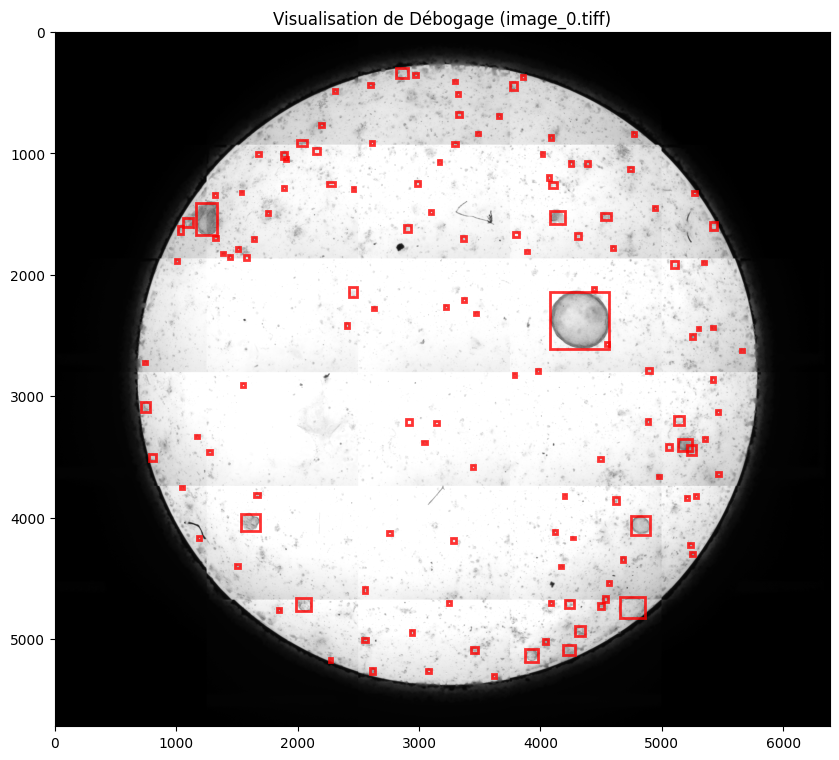

In [ ]:
IMG_TO_DEBUG = "5/train/Macros/Plate_13/image_0/image_0.tiff"
JSON_TO_DEBUG = "5/train/Macros/Plate_13/image_0/image_0_Annotator_A.json"

# CONVERSION DES CHEMINS (si vous êtes sur Windows) :
# Utilisez la conversion pour vous assurer que les chemins sont corrects
if os.name == 'nt': # Windows
    IMG_TO_DEBUG = IMG_TO_DEBUG.replace('/', os.sep)
    JSON_TO_DEBUG = JSON_TO_DEBUG.replace('/', os.sep)

print(f"Chemin de l'image (test) : {IMG_TO_DEBUG}")

# Exécutez le débogage sur la première image en erreur
debug_visualisation(IMG_TO_DEBUG, JSON_TO_DEBUG)


Dimensions Originales : (5720, 6385)
Dimensions Paddées : (6144, 6656)


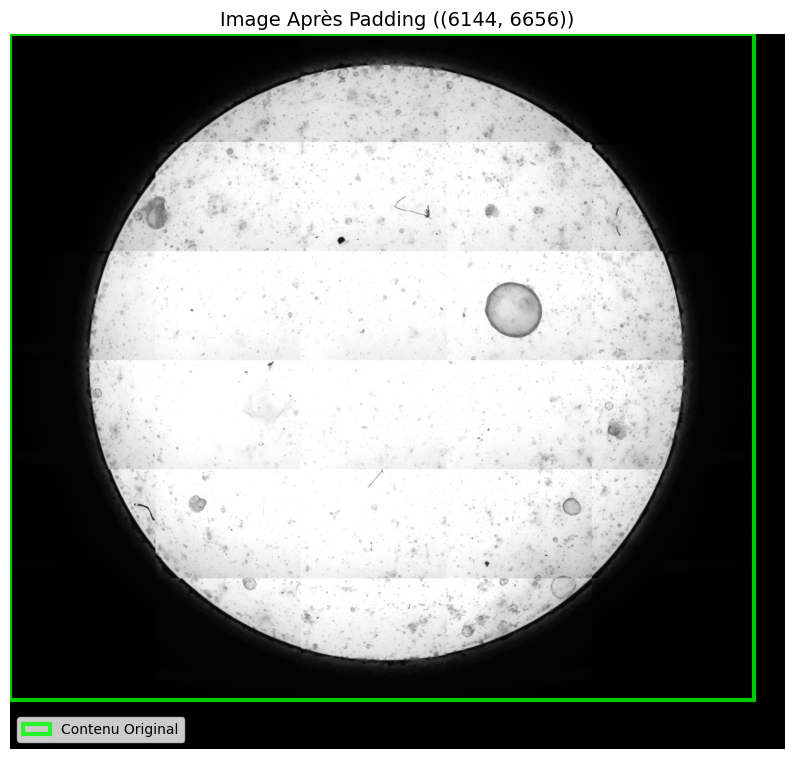

✅ SUCCÈS : Le contenu original (zone verte) a été préservé.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# --- FONCTIONS load_img (supposées chargées et corrigées) ---
# Vous devez avoir img_path, load_img, et load_annotations définis dans votre environnement.

# --- 2. FONCTION DE TEST VISUEL ET LOGIQUE ---
def test_pad_img_integrity(img_path, crop_size):
    """
    Charge l'image, la padde, et vérifie si le contenu original est conservé.
    """
    try:
        # Charge l'image brute (Utilisez votre fonction load_img corrigée ici)
        img_original = load_img(img_path)
        
        # 1. PADDING
        img_padded = pad_img(img_original, img_original.shape[0], img_original.shape[1], crop_size)
        
        print(f"Dimensions Originales : {img_original.shape}")
        print(f"Dimensions Paddées : {img_padded.shape}")

        # 2. VÉRIFICATION LOGIQUE
        # Vérifie si le contenu non-zero de l'image originale existe toujours dans l'image paddée.
        # Si la somme des pixels non-zeros (ou la moyenne des pixels > 50) est > 0, l'image n'est pas vide.
        original_mean = np.mean(img_original)
        padded_content_mean = np.mean(img_padded)
        
        if original_mean < 1.0 and np.max(img_original) == 0:
             print("⚠️ ATTENTION: L'image originale semble déjà être presque vide (moyenne très faible).")
        
        if np.all(img_padded == 0):
            print("❌ ÉCHEC CRITIQUE: L'image paddée est entièrement vide (remplie de zéros)!")
            return

        # 3. VÉRIFICATION VISUELLE DE CONSERVATION
        
        # Normalisation pour l'affichage
        visual_slice = img_padded
        if visual_slice.dtype != np.uint8:
            visual_slice = (visual_slice - np.min(visual_slice)) / (np.max(visual_slice) - np.min(visual_slice))
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(visual_slice, cmap='gray')
        ax.set_title(f"Image Après Padding ({img_padded.shape})", fontsize=14)
        ax.axis('off')
        
        # Dessiner un rectangle pour montrer l'étendue du contenu original
        h_orig, w_orig = img_original.shape
        rect = plt.Rectangle((0, 0), w_orig, h_orig,
                             fill=False, 
                             edgecolor='lime', 
                             linewidth=3, 
                             alpha=0.8,
                             label="Contenu Original")
        ax.add_patch(rect)
        plt.legend()
        plt.show()
        
        print("✅ SUCCÈS : Le contenu original (zone verte) a été préservé.")

    except Exception as e:
        print(f"❌ ERREUR LORS DU TEST DE PADDING: {type(e).__name__} - {e}")
        print("Vérifiez l'importation de load_img et la variable img_path.")


# --- EXÉCUTION DU TEST ---
# REMPLACER CES VARIABLES par celles utilisées dans votre pipeline principal
IMG_TO_TEST = "5/train/Macros/Plate_13/image_0/image_0.tiff" 
CROP_SIZE = 512

# Note : Vous devez avoir load_img() fonctionnel dans votre environnement pour exécuter ceci.
test_pad_img_integrity(IMG_TO_TEST, CROP_SIZE)

In [3]:
# --- CONFIGURATION DE TEST (Ajustez les chemins si nécessaire) ---
IMG_PATH_TEST = "5//train//Macros//Plate_13//image_0//image_0.tiff" 
JSON_PATH_TEST = "5//train//Macros//Plate_13//image_0//image_0_Annotator_A.json"
CROP_SIZE = 512
DST_FOLDER_TEST = "./temp_output_test" # Dossier temporaire pour simuler la sauvegarde
if not os.path.exists(DST_FOLDER_TEST): os.makedirs(DST_FOLDER_TEST)

# --- PRÉPARATION DES ENTRÉES DE CROP_IMG ---
try:
    # 1. Charger et traiter l'image (via vos fonctions définies)
    img_original = load_img(IMG_PATH_TEST)
    img_height_orig, img_width_orig = img_original.shape
    
    # 2. Padder l'image
    img_padded = pad_img(img_original, img_height_orig, img_width_orig, CROP_SIZE)
    
    # 3. Charger les annotations
    bboxes_original = load_annotations(JSON_PATH_TEST, img_height_orig, img_width_orig)

    # 4. Initialiser les compteurs
    images_json_start = []
    img_id_start = 0
    obj_count_start = 0
    annotations_json_start = []
    annotator_name = JSON_PATH_TEST.split('_')[-1].split('.')[0] # 'Annotator_A'
    
    print(f"Démarrage du test pour une image {img_height_orig}x{img_width_orig}")
    print(f"Annotations brutes trouvées : {len(bboxes_original)}")

    # ----------------------------------------------------------------------
    # 2. APPEL DE LA FONCTION (AVEC VOS ARGUMENTS NON-CORRIGÉS)
    # ----------------------------------------------------------------------
    
    result_images_json, final_img_id, result_annotations_json, final_obj_count = crop_img(
        img_padded,
        img_height_orig,        # HAUTEUR ORIGINALE (si c'est le bug)
        img_width_orig,         # LARGEUR ORIGINALE (si c'est le bug)
        bboxes_original,
        IMG_PATH_TEST,
        CROP_SIZE,
        DST_FOLDER_TEST,
        images_json_start,
        img_id_start,
        annotator_name,
        annotations_json_start,
        obj_count_start
    )

    # ----------------------------------------------------------------------
    # 3. AFFICHAGE DU RÉSULTAT
    # ----------------------------------------------------------------------
    
    print("\n--- RÉSULTAT DE L'EXÉCUTION DE crop_img ---")
    print(f"Nombre de crops créés (images_json) : {len(result_images_json)}")
    print(f"Nombre total d'annotations générées : {len(result_annotations_json)}")
    print(f"Nouvel ID image atteint : {final_img_id}")
    
    if len(result_images_json) > 0:
        print("\nAPERÇU DU PREMIER ÉLÉMENT images_json :")
        print(result_images_json[0])
        print("\nAPERÇU DE LA PREMIÈRE ANNOTATION (annotations_json) :")
        print(result_annotations_json[0])
        
except Exception as e:
    print("\n❌ ERREUR CRITIQUE LORS DE L'EXÉCUTION :")
    print(f"Type d'erreur : {type(e).__name__}")
    print(f"Message d'erreur : {e}")
    print("\nLe code a planté. L'erreur est située dans l'une des lignes entre load_img et la fin du try/except.")

Démarrage du test pour une image 5720x6385
Annotations brutes trouvées : 135
 image_0 

--- RÉSULTAT DE L'EXÉCUTION DE crop_img ---
Nombre de crops créés (images_json) : 64
Nombre total d'annotations générées : 106
Nouvel ID image atteint : 64

APERÇU DU PREMIER ÉLÉMENT images_json :
{'id': 0, 'file_name': '_image_0__patch_0_4.jpg', 'height': 5720, 'width': 6385, 'annotator': 'A'}

APERÇU DE LA PREMIÈRE ANNOTATION (annotations_json) :
{'image_id': 0, 'id': 0, 'category_id': 0, 'bbox': [240, 473, 35, 32], 'area': 884, 'iscrowd': 0}
